In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime

In [127]:
def assessment(data, x_feature, y_feature, index=-1):
    """
    Visualization function to show histograms and scatter plots.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    sns.histplot(x=x_feature, kde=False, color="g").set_xlabel(x_feature, fontsize=10)
    if index >= 0:
        plt.scatter(x_feature, y_feature, c="r", edgecolors="w")
    else:
        sns.scatterplot(x=x_feature, y=y_feature, data=data, hue=None, legend=False).set_xlabel(x_feature, fontsize=10)
    plt.show()

In [109]:
def correlation_map(data, feature, number):
    """
    Develops a heatmap showing correlations.
    """
    most_correlated = data.corr().nlargest(number, feature)[feature].index
    correlation = data[most_correlated].corr()

    mask = np.zeros_like(correlation)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        fig, axes = plt.subplots(figsize=(20, 10))
        sns.heatmap(
            correlation,
            mask=mask,
            vmin=-1,
            vmax=1,
            square=True,
            center=0,
            annot=True,
            annot_kws={"size": 8},
            cmap="PRGn",
        )
    plt.show()

In [111]:
# Load and preprocess the data
data = pd.read_csv("./dataset/smart_grid_stability_augmented.csv")
map1 = {"unstable": 0, "stable": 1}
data["stabf"] = data["stabf"].replace(map1)
data = data.sample(frac=1)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14952\1042916931.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["stabf"] = data["stabf"].replace(map1)


In [113]:
print(data.head())

           tau1      tau2      tau3      tau4        p1        p2        p3  \
19490  4.927621  3.341739  5.760302  6.298348  4.927582 -1.869849 -1.957185   
55339  3.588146  7.735461  8.127657  8.312566  3.594254 -0.860522 -1.709962   
56146  3.293038  6.928027  3.001147  8.001799  4.157492 -1.599810 -0.694437   
13230  9.136937  9.139493  3.985057  1.908408  3.056795 -1.837689 -0.554441   
16730  7.859082  4.441817  5.391551  1.542327  3.861322 -1.444219 -0.542101   

             p4        g1        g2        g3        g4      stab  stabf  
19490 -1.100548  0.120890  0.643383  0.388038  0.311167 -0.003837      1  
55339 -1.023771  0.915030  0.305078  0.566615  0.406361  0.041373      0  
56146 -1.863245  0.332767  0.628440  0.281961  0.972994  0.048264      0  
13230 -0.664664  0.332249  0.720667  0.498313  0.669428  0.010268      0  
16730 -1.875002  0.924844  0.196694  0.759230  0.290764  0.040080      0  


In [115]:
X_dataframe = data.drop('stabf', axis=1)
y_dataframe = data['stabf']

ValueError: If using all scalar values, you must pass an index

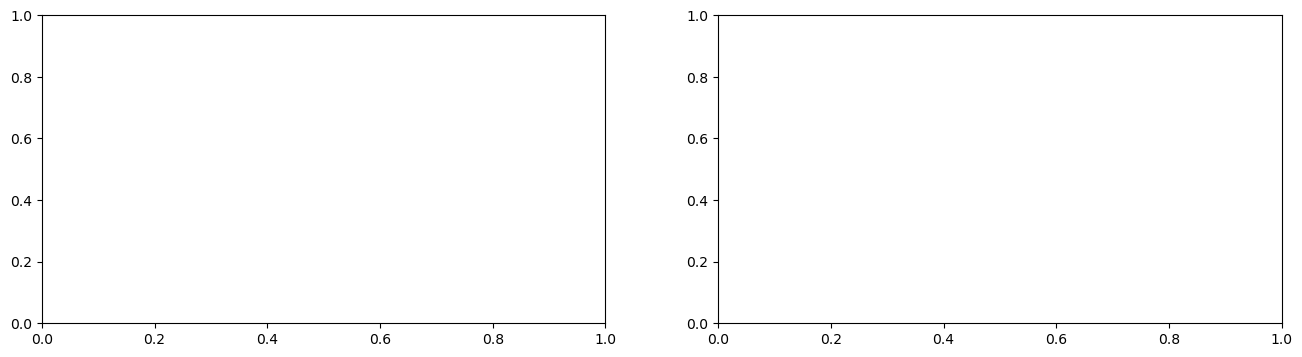

In [131]:
assessment(data, X_dataframe, y_dataframe, index=0)

In [71]:
X = data.iloc[:, :12].values
y = data.iloc[:, 13].values

In [43]:
X_train, X_test = X[:54000], X[54000:]
y_train, y_test = y[:54000], y[54000:]

In [45]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [47]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [49]:
# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(12, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, 12)
        self.fc4 = nn.Linear(12, 1)
        self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.elu(self.fc1(x))
        x = self.elu(self.fc2(x))
        x = self.elu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

In [51]:
# Initialize the model, loss function, and optimizer
model = NeuralNetwork()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [53]:
# Cross-validation
kf = KFold(10, shuffle=True, random_state=10)
start_time = datetime.now()
print("Model evaluation\n")

Model evaluation



In [55]:
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    x_train, x_val = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val = y_train[train_idx], y_train[val_idx]
    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train_fold)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(x_val)
        val_loss = criterion(val_outputs, y_val)
        val_accuracy = accuracy_score(y_val.numpy(), (val_outputs.numpy() > 0.5).astype(int))
        print(f"Fold {fold + 1} - Loss: {val_loss:.4f} | Accuracy: {val_accuracy * 100:.2f}%")

Fold 1 - Loss: 0.4730 | Accuracy: 80.78%
Fold 2 - Loss: 0.3984 | Accuracy: 81.50%
Fold 3 - Loss: 0.3671 | Accuracy: 82.72%
Fold 4 - Loss: 0.3331 | Accuracy: 84.56%
Fold 5 - Loss: 0.2677 | Accuracy: 88.70%
Fold 6 - Loss: 0.1956 | Accuracy: 92.20%
Fold 7 - Loss: 0.1300 | Accuracy: 94.91%
Fold 8 - Loss: 0.1265 | Accuracy: 95.06%
Fold 9 - Loss: 0.1036 | Accuracy: 95.85%
Fold 10 - Loss: 0.1057 | Accuracy: 95.65%


In [57]:
# Test the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    y_pred = (y_pred.numpy() > 0.5).astype(int)
    cm = confusion_matrix(y_test.numpy(), y_pred)
    test_accuracy = accuracy_score(y_test.numpy(), y_pred)

print(f"\nConfusion Matrix:\n{cm}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

end_time = datetime.now()
print("\nStart time", start_time)
print("End time", end_time)
print("Time elapsed", end_time - start_time)


Confusion Matrix:
[[3691  161]
 [ 132 2016]]
Test Accuracy: 95.12%

Start time 2025-02-19 17:18:10.979786
End time 2025-02-19 17:18:33.840874
Time elapsed 0:00:22.861088


In [59]:
cm = pd.DataFrame(data=confusion_matrix(y_test, y_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
print(cm)

                 Predicted Unstable  Predicted Stable
Actual Unstable                3691               161
Actual Stable                   132              2016


In [61]:
print(f'Accuracy per the confusion matrix: {((cm.iloc[0, 0] + cm.iloc[1, 1]) / len(y_test) * 100):.2f}%')

Accuracy per the confusion matrix: 95.12%


In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96      3852
         1.0       0.93      0.94      0.93      2148

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000

